## EEP 502: Analytical Methods for Electrical Engineering
    
# Final project
## Due December 14, 2024 at 11:59 PM
Copyright &copy; 2024, University of Washington

<hr>

**Instructions**: Choose **<u>one</u>** of the following problems. Solve the problem and then write up your solution in a stand-alone Jupyter Notebook. Your notebook should have the following elements:

- Problem statement
- Mathematical description of the solution
- Executable, commented, clear code

You will be graded on how well your notebook reads like a nicely formated, well written report. You must:

- Write mathematical descriptions using complete sentences, paragraphs, and LaTeX formulas.
- Comment your code as necessary, with a description of what each function does, and all major steps.
- Label plots axes, use legends, and use plot titles.
- Before submitting a notebook, choose Kernel -> Restart and Run All to make sure your notebook runs when the cells are evaluated in order.

<span style="color: red'">
Although you may discuss the project with others, you must turn in your own, original work.
</span>


In [1]:
import networkx as nx
import math
import scipy
import scipy.integrate as spi
import numpy as np
import sympy as sm
sm.init_printing(use_latex='mathjax')
import matplotlib.pyplot as plt
import itertools
import random
%matplotlib inline

# Differential Equations for Neural Networks

The computational neural networks we have been studying are quite far from what is happening in biology. A slightly more realistic model is to admit that each neuron $i$ in a network has a time varying firing rate $x_i$, for $i$ equal $1$ to $n$. We let $W \in \mathbb{R}^{n \times n}$ be weight matrix, and $b \in \mathbb{R}^n$. The dynamics of such a neural network are

$$
\dot x_i = g \left (
\sum_{j=1}^n w_{i,j} x_j + b_i
\right )
$$

where is the nonlinearity

$$
g(x) = \frac{1}{1+e^{-x}} - \frac{1}{2} .
$$

*a)* Show through simulation that the matrix

$$
W = - \begin{pmatrix}
1 & 2 & 0 \\
0 & 1 & 2 \\
2 & 0 & 1
\end{pmatrix}
$$

with $b = 0$ results in oscillations. This is called a ring oscillator. Draw a graph representation of it. Now show through simulation that a ring of $n$ neurons so arranged oscillates when $n$ is odd, but not when it is even.

*b)* Define $W$ and $b$ so that the resulting network is bistable. That is, when one neuron is on in steady state, another is off, and *vice versa*. Simulate the system with different initial conditions. Draw a graph representation of your network.

*c)* Build a network that contains two subnetworks that oscillate, that are connected in such a way that if one subnetwork oscillates, it prevents the other from oscillating, and *vice versa*. Simulate the system with different initial conditions to show the desired behavior. Draw a graph representation of your network.

*d)* Define $W \in \mathbb{R}^{n \times n}$ and $b \in \mathbb{R}^n$ with $n = 50$ to be a random neural network.

Given a number $p \in [0,1]$, define a random matrix $A$ as follows. For each $i,j$, choose $r \in [0,1]$ randomly. Then put

$$
A_{i,j} = \left \{
\begin{array}{ll}
1 & \mathrm{if} & r \leq \frac{p}{2} \\
-1 & \mathrm{if} & \frac{p}{2} < r \leq p \\
0 & \mathrm{otherwise}.
\end{array}
\right .
$$

Then put

$$
W = A - I
$$

where $I$ is the identity matrix. Through simulations with $n=20$, explain the various behaviors you can get with various values of $p$.

Computational neural networks, used in machine learning and deep learning models, are inspired by neurons in biology. These artificial neural networks, similar to biological neural networks, use a node which peforms a linear regression based on the weighted inputs to the node and a bias threshold to shift the activation threshold of the node. <br> <br>
At a high-level, the dynamics of a computational neural network node can be modeled with just the following formula,
$$f(x) = \sum_{j=1}^n w_{i,j} x_j + b_i$$  
Here, $f(x)$ indicates whether a node fired, which occurs if the output exceeds a threshold value. The threshold value is solved by summing all inputs ($x$) from all nodes ($n$) in the network, multiplied by their respective weights ($w$) which indicates the significance of the input, and then adding the bias threshold ($b$). <br><br>
Although the computational neural network model is similar to biological neural networks, neurons in biology have a time varying firing rate. The following formula can be used to represent the nonlinear time varying firing rate of each neuron. 
$$g(x) = \frac{1}{1+e^{-x}}-\frac{1}{2}$$
While the computational neural network formula above can be used as an input to our nonlinearity function.



As the firing rate is a derivative with respect to time and no other factor, the nonlinearity equation for each neuron can be solved as an ordinary differential equation. Better, since neurons are typically modelled as one element of a neural network, the whole neural network lends itself to be treated as a system of ordinary differential equations (ODEs). Assuming the neural network is a system of ODEs, then according the Existence and Uniqueness Theorem there will be a solution, and the solution will be unique for each neuron in the network. Knowing that each neuron has a solution, the behavior can then be modelled at any given point if an initial condition is provided.

In [2]:
def nonlinearity_func(x):
    """Model of nonlinearity function that represents the time varying component of a neuron's firing rate
    

    Interface Control Document (ICD)
    | I/O       | Signal Name                   | Description                                                                                                                       |
    | -         | -                             | -                                                                                                                                 |
    | input     | x                             | Summed neuron inputs and activiation bias                                                                                         |
    | output    | g_x                           | Neuron firing output                                                                                                              |


    No Exception Handling Provided
    """

    return ((1/(1+np.exp(-x))) - (1/2))

In [3]:
def neuron_firing_rate_func(    t,
                                weight_vector_i,
                                neuron_firing_rate_vector_i,
                                neuron_bias_i
                                ):
    """Function sums the weighted inputs from all the neurons in the neural network into neuron $i$ and adds an activation threshold bias to change the firing threshold of neuron $i$.
       
    
    Function feeds the weighted neuron input + activation threshold bias into the nonlinearity function to model the firing rate of neuron $i$ as a function of time. 


    Interface Control Document (ICD)
    | I/O       | Signal Name                   | Description                                                                                                                       |
    | -         | -                             | -                                                                                                                                 |
    | input     | t                             | time variable. time component MUST be first varible due to solve_ivp function requirements                                        |
    | input     | weight_vector_i               | Matrix of real numbers (size nxn) that defines the strength (weight) of connections between neurons $j$ and neuron $i$            |
    | input     | neuron_firing_rate_vector_i   | Vector of real numbers, of size $n$ neurons, that models firing rate for each neuron $j$ in the neural network.                   |
    | input     | neuron_bias_i                 | Real number that adjusts neuron $i$'s activation threshold                                                                        |
    | output    | nonlinearity_func             | Real number that models firing rate of neuron $i$ in a neural network. Refers to g(x) nonlinearity equation                       |


    No Exception Handling Provided
    """
    # Calculate the weighted sum of neuron firing rates into neuron $i$
    x = np.dot(weight_vector_i,neuron_firing_rate_vector_i) + neuron_bias_i

    # Nonlinearity function g(x) models the activation of neuron x_i
    return nonlinearity_func(x)

In [4]:
def neuron_ode( weight_matrix_i,
                init_neuron_firing_rate_vector_i,
                time_steps_i,
                neuron_bias_i,    
                t_eval_i
                ):
    """Function uses an ODE solver to calculate the activation rate for each neuron in the neural network as a function of time


    Interface Control Document (ICD)
    | I/O       | Signal Name                       | Description                                                                                                                                                                                                               |
    | -         | -                                 | -                                                                                                                                                                                                                         |
    | input     | weight_matrix_i                   | Matrix of real numbers (size nxn) that defines the strength (weight) of connections between neurons $j$ and neuron $i$                                                                                                    |
    | input     | init_neuron_firing_rate_vector_i  | Initial vector of real numbers, of size $n$ neurons, that models firing rate for each neuron $j$ in the neural network. The ODE solver will calculate firing rates as a function of time but requires an initial state    |
    | input     | time_steps_i                      | List that contains interval of integration (t0, tf). The ODE solver starts with t=t0 and integrates until it reaches t=tf. Both t0 and tf must be floats or values interpretable by the float conversion function.        |
    | input     | neuron_bias_i                     | Real number that adjusts neuron $i$'s activation threshold                                                                                                                                                                |
    | input     | t_eval_i                          | Times steps which to store the evaluated solution, must be sorted and lie within time_steps_i. If None (default), use points selected by the ODE solver.                                                                  |
    | output    | neuron_activation_rates.t         | Array of real numbers returned by the ODE solver that contains the evaluation times t, constrained by t_eval_i                                                                                                            |
    | output    | neuron_activation_rates.y         | Array of real numbers returned by the ODE solver that contains the evaluated values y for each time interval t. Total y is constrained by t_eval_i                                                                        |

    
    No Exception Handling Provided
    """

    # Use scipy solve_ivp to solve ODE equations. 
    # Currently unsure of which ODE method to use, so following scipy documentation I will use the default method, RK45, since it returns reasonable values
    neuron_activation_rates =   spi.solve_ivp(  lambda t,x : neuron_firing_rate_func(t,weight_matrix_i,x,neuron_bias_i),
                                                time_steps_i,
                                                init_neuron_firing_rate_vector_i,
                                                "RK45",
                                                t_eval_i
                                                )
    return neuron_activation_rates.t,neuron_activation_rates.y

In [5]:
# Based on the weighted matrix conditions, activation threshold bias, and odd number of neurons specified by a), each neuron should exhibit oscillatory behavior

# Setup initial conditions to model 3 neuron neural network ring oscillator
# Initializing weighted matrix
W_ring_osc = np.array([
                [1,2,0],
                [0,1,2],
                [2,0,1]
])
W_ring_osc = (W_ring_osc*(-1))
# Initializing activation bias
b = np.zeros(3)
# Setting timestep range for ODE func
time_steps = [0,200]
# Initializing neuron firing rates for all neurons in the neural network to a random real number between 0 Hz and 13 Hz. 
# This range appears to be a reasonable neural firing rates for alpha,delta,theta,and beta brain waves
# The animal is not specified, but assuming brain activity observations are on humans, based on the surronding article context.
# Wikipedia. [Neural oscillation]. Wikipedia. [Online]. Available: https://en.wikipedia.org/wiki/Neural_oscillation (Accessed: Dec. 7, 2024).
init_neuron_firing_rate_vector = np.array([random.uniform(0,30) for i in range(3)]).reshape(3,)
# Setting up evaluation points for ODE func
t_eval = np.linspace(0, 200, 2000)


W_ring_osc, init_neuron_firing_rate_vector,b

(array([[-1, -2,  0],
        [ 0, -1, -2],
        [-2,  0, -1]]),
 array([17.19116025,  3.92667894,  7.49505099]),
 array([0., 0., 0.]))

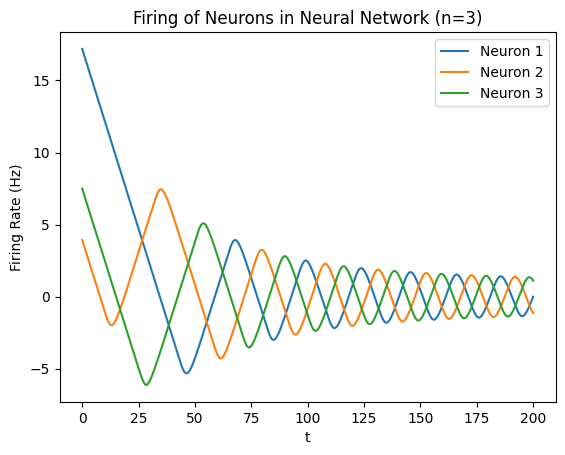

In [6]:
# Plot the simulated behavior of a three neuron neural network
t,y = neuron_ode(W_ring_osc,init_neuron_firing_rate_vector,time_steps,b,t_eval)

# Plot the firing of each neuron in neural network
for i in range(3):
    plt.plot(t, y[i], label=f"Neuron {i+1}")
plt.title("Firing of Neurons in Neural Network (n=3)")
plt.xlabel("t")
plt.ylabel("Firing Rate (Hz)")
plt.legend()

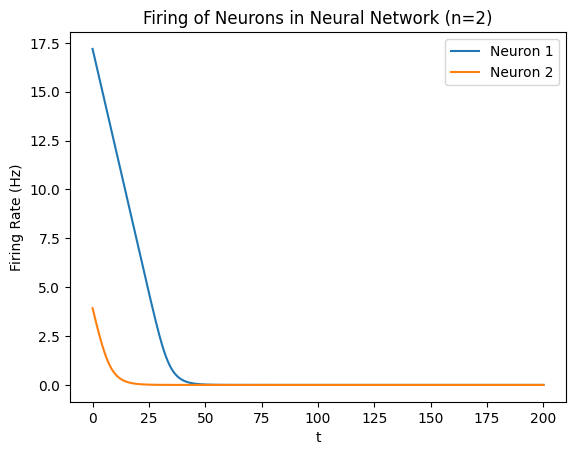

In [7]:
# By reducing the number of neurons from an odd 3 neurons to an even 2 neurons, the two neurons should not oscillate and instead converge to zero as their outputs are dampened

# Plot the simulated behavior of a two neuron neural network
t,y = neuron_ode(W_ring_osc[:2,:2],init_neuron_firing_rate_vector[:2],time_steps,b[:2],t_eval)

# Plot the firing of each neuron in neural network
for i in range(2):  
    plt.plot(t, y[i], label=f"Neuron {i+1}")
plt.title("Firing of Neurons in Neural Network (n=2)")
plt.xlabel("t")
plt.ylabel("Firing Rate (Hz)")
plt.legend()

In [8]:
def gen_nn_nodes(num_biases_i,G_i):
    """Function generates the nodes of the neural network based on the depth of activation threshold bias vector $b$.


    Interface Control Document (ICD)
    | I/O       | Signal Name                   | Description                                                                                                                       |
    | -         | -                             | -                                                                                                                                 |
    | input     | num_biases_i                  | Number of biases is used to determine number of nodes (neurons) to add to the networkx graph                                      |
    | output    | G_i                           | Networkx graph output, now with nodes                                                                                             |


    No Exception Handling Provided
    """

    # start node count from 1 rather than zero, because it matches the legend in the neuron firing graphs
    for i in range(1,len(num_biases_i)+1):
        G_i.add_node(i)

    return G_i

In [9]:
def gen_nn_edges(adjacency_matrix_i,G_i):
    """Function generates the edges of the neural network based on the weight matrix $W$ of the network.


    Interface Control Document (ICD)
    | I/O       | Signal Name                   | Description                                                                                                                       |
    | -         | -                             | -                                                                                                                                 |
    | input     | adjacency_matrix_i            | The weight matrix is the adjacency matrix of the neural network, which describes the edges of the graph                           |
    | output    | G_i                           | Networkx graph output, now with edges                                                                                             |


    No Exception Handling Provided
    """
    
    dimensions = adjacency_matrix_i.shape
    rows,columns = dimensions

    for i in range(1,rows+1):
        for j in range(1,columns+1):
            if (adjacency_matrix_i[i-1,j-1] != 0):
                G_i.add_edge(i,j,weight=adjacency_matrix_i[i-1,j-1])

    return G_i

In [10]:
def draw_nn(G_i,ax_i):
    """Function draws the networkx neural network graph. 


    Interface Control Document (ICD)
    | I/O       | Signal Name                   | Description                                                                                                                       |
    | -         | -                             | -                                                                                                                                 |
    | input     | G_i                           | Networkx graph of the neural network that will be drawn                                                                           |
    | input     | ax_i                          | Graph plot that the networkx graph will be drawn in                                                                               |


    No Exception Handling Provided
    """
    # Draw neural network
    nx.draw(G_i,
            ax=ax_i,
            pos=nx.circular_layout(G_i),
            with_labels=True,
            node_color='#444444',
            font_color="white")
    nx.draw_networkx_edge_labels(G_i, 
                                pos=nx.circular_layout(G_i), 
                                edge_labels=nx.get_edge_attributes(G_i, "weight"))

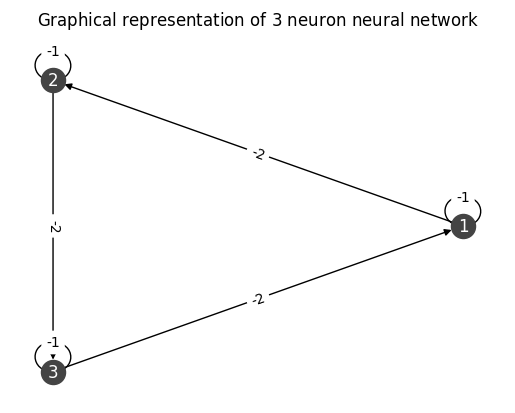

In [11]:
# Graphical representation of 3 neuron neural network based on the weighted connection matrix W

# Create networkX graph variable
G_ring_oscillator = nx.DiGraph()
G_ring_oscillator = gen_nn_nodes(b,G_ring_oscillator)
G_ring_oscillator = gen_nn_edges(W_ring_osc,G_ring_oscillator)

# Create graph
basic_graph,ax = plt.subplots(1,1)
ax.set_title("Graphical representation of $%d$ neuron neural network" % (3))

draw_nn(G_ring_oscillator,ax)

In [12]:
def gen_initial_conditions_array(iterations_i,num_neurons_i):
    """Create multiple initial condition vectors to feed into neuron ODE function


    Interface Control Document (ICD)
    | I/O       | Signal Name                       | Description                                                                                                                   |
    | -         | -                                 | -                                                                                                                             |
    | input     | iterations_i                      | Determines the number of initial condition vectors to create                                                                  |
    | input     | num_neurons_i                     | Determines the number of neurons in each initial condition vector                                                             |
    | output    | init_neuron_firing_rate_vector_o  | The array of initial condition vectors to be used by the ODE solver                                                           |


    No Exception Handling Provided
    """
    init_neuron_firing_rate_vector_o = []
    for iter in range(iterations_i):
        # Initializing neuron firing rates for all neurons in the neural network to a random real number between 0 Hz and 13 Hz. 
        # This range appears to be a reasonable neural firing rates for alpha,delta,theta,and beta brain waves
        # The animal is not specified, but assuming brain activity observations are on humans, based on the surronding article context.
        # Wikipedia. [Neural oscillation]. Wikipedia. [Online]. Available: https://en.wikipedia.org/wiki/Neural_oscillation (Accessed: Dec. 7, 2024).
        init_neuron_firing_rate = np.array([random.uniform(0,13) for i in range(num_neurons_i)]).reshape(num_neurons_i,) 
        init_neuron_firing_rate_vector_o.append(init_neuron_firing_rate)
    return init_neuron_firing_rate_vector_o

In [13]:
# Basing initial weighted matrix conditions and activation threshold bias on HW5 bistable switch problem

# Setup initial conditions to model 3 neuron neural network ring oscillator
# Initializing weighted matrix for bistability, using HW5 bistable problem as an example
W_bistable = np.array([
                [0,-0.5],
                [-0.5,0],
])
# Setting timestep range for ODE func
time_steps = [0,200]
# Initializing activation bias to be equal, using HW5 bistable problem as an example
b = np.array([17/4,17/4])
# Setting up evaluation points for ODE func
t_eval = np.linspace(0, 200, 2000)

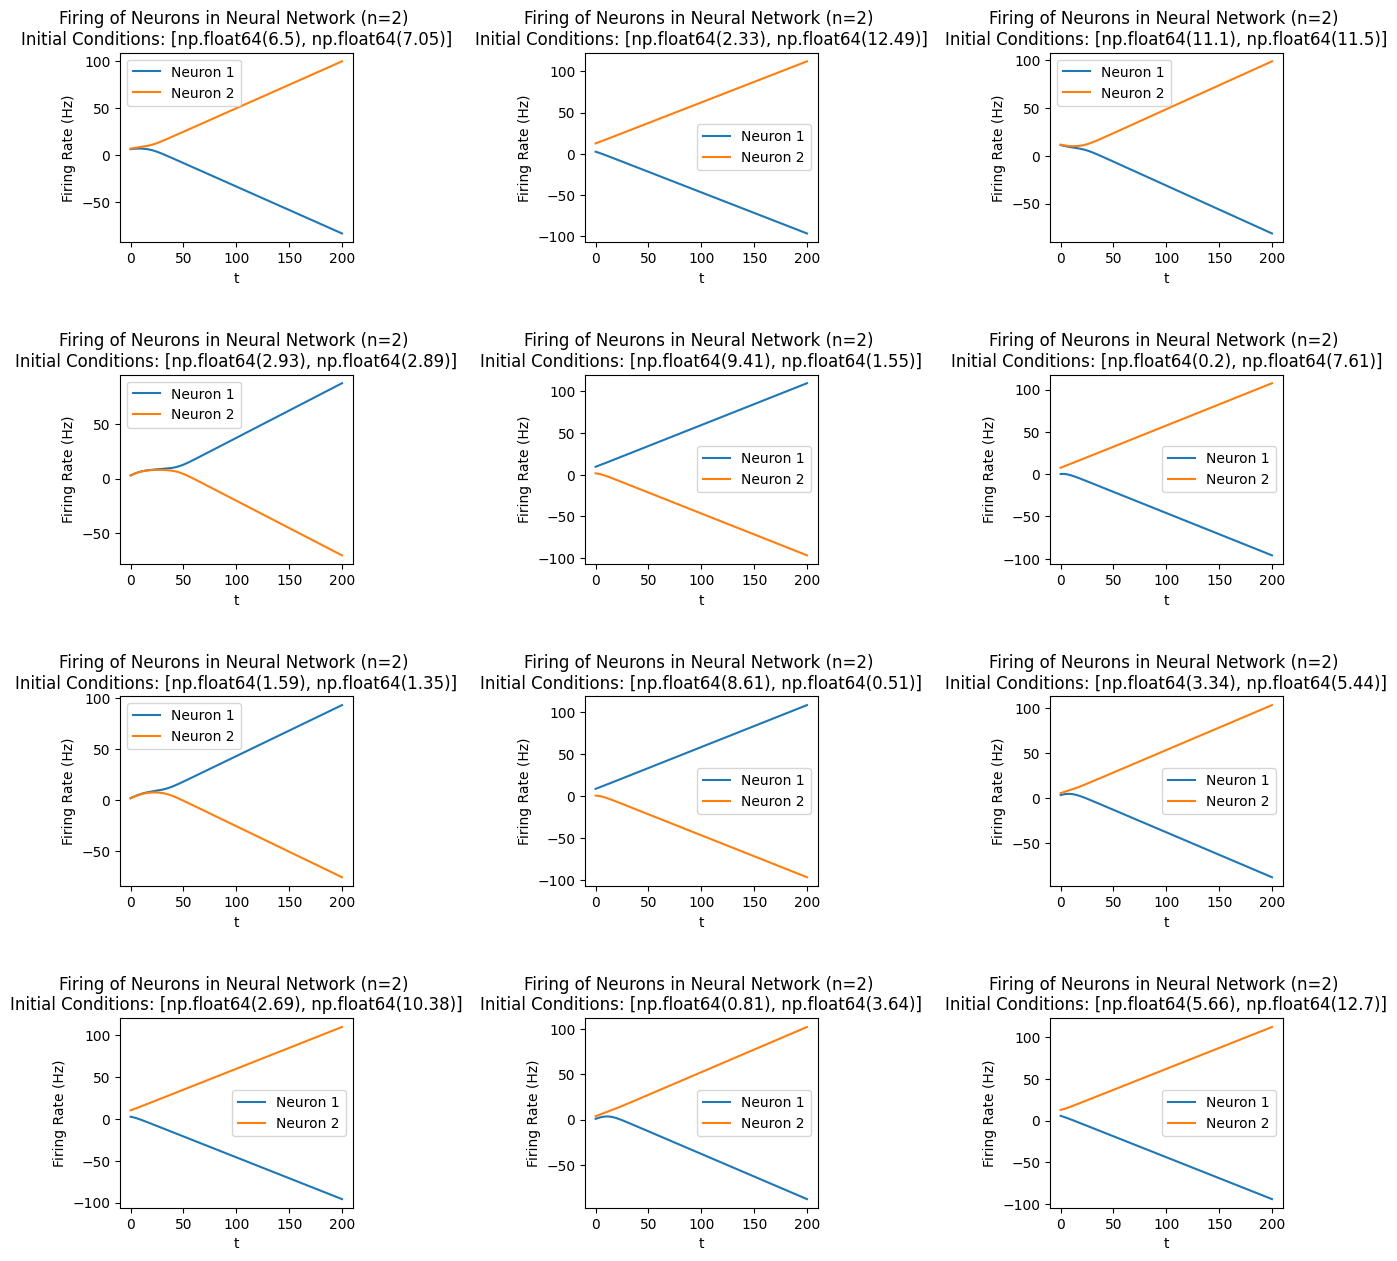

In [14]:
# Generate array of different initial conditions
init_neuron_firing_rate_vector = gen_initial_conditions_array(12,2)

# Generate subplot variable
num_rows = 4
num_cols = 3
fig,xn = plt.subplots(num_rows,num_cols,figsize=(15,15))
plt.subplots_adjust(wspace=1, hspace=0.7)

for iter in range(len(init_neuron_firing_rate_vector)):
    # Plot the simulated behavior of a three neuron neural network
    t,y = neuron_ode(W_bistable,init_neuron_firing_rate_vector[iter],time_steps,b,t_eval)

    round_initial_conditions = np.round(init_neuron_firing_rate_vector[iter],2)
    a = xn[int(iter/num_cols), iter%num_cols]
    # Plot the firing of each neuron in neural network
    for i in range(2):
        a.plot(t, y[i], label=f"Neuron {i+1}")
    a.set_title(f"Firing of Neurons in Neural Network (n=2) \nInitial Conditions: {list(round_initial_conditions)}")
    a.set_xlabel("t")
    a.set_ylabel("Firing Rate (Hz)")
    a.legend()

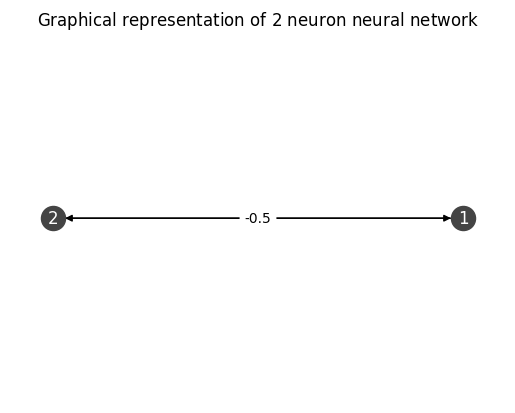

In [15]:
# Graphical representation of bistable neural network based on the weighted connection matrix W

# Create networkX graph variable
G_bistable = nx.DiGraph()
G_stable = gen_nn_nodes(b,G_bistable)
G_stable = gen_nn_edges(W_bistable,G_bistable)

# Create graph
basic_graph,ax = plt.subplots(1,1)
ax.set_title("Graphical representation of $%d$ neuron neural network" % (2))

draw_nn(G_stable,ax)

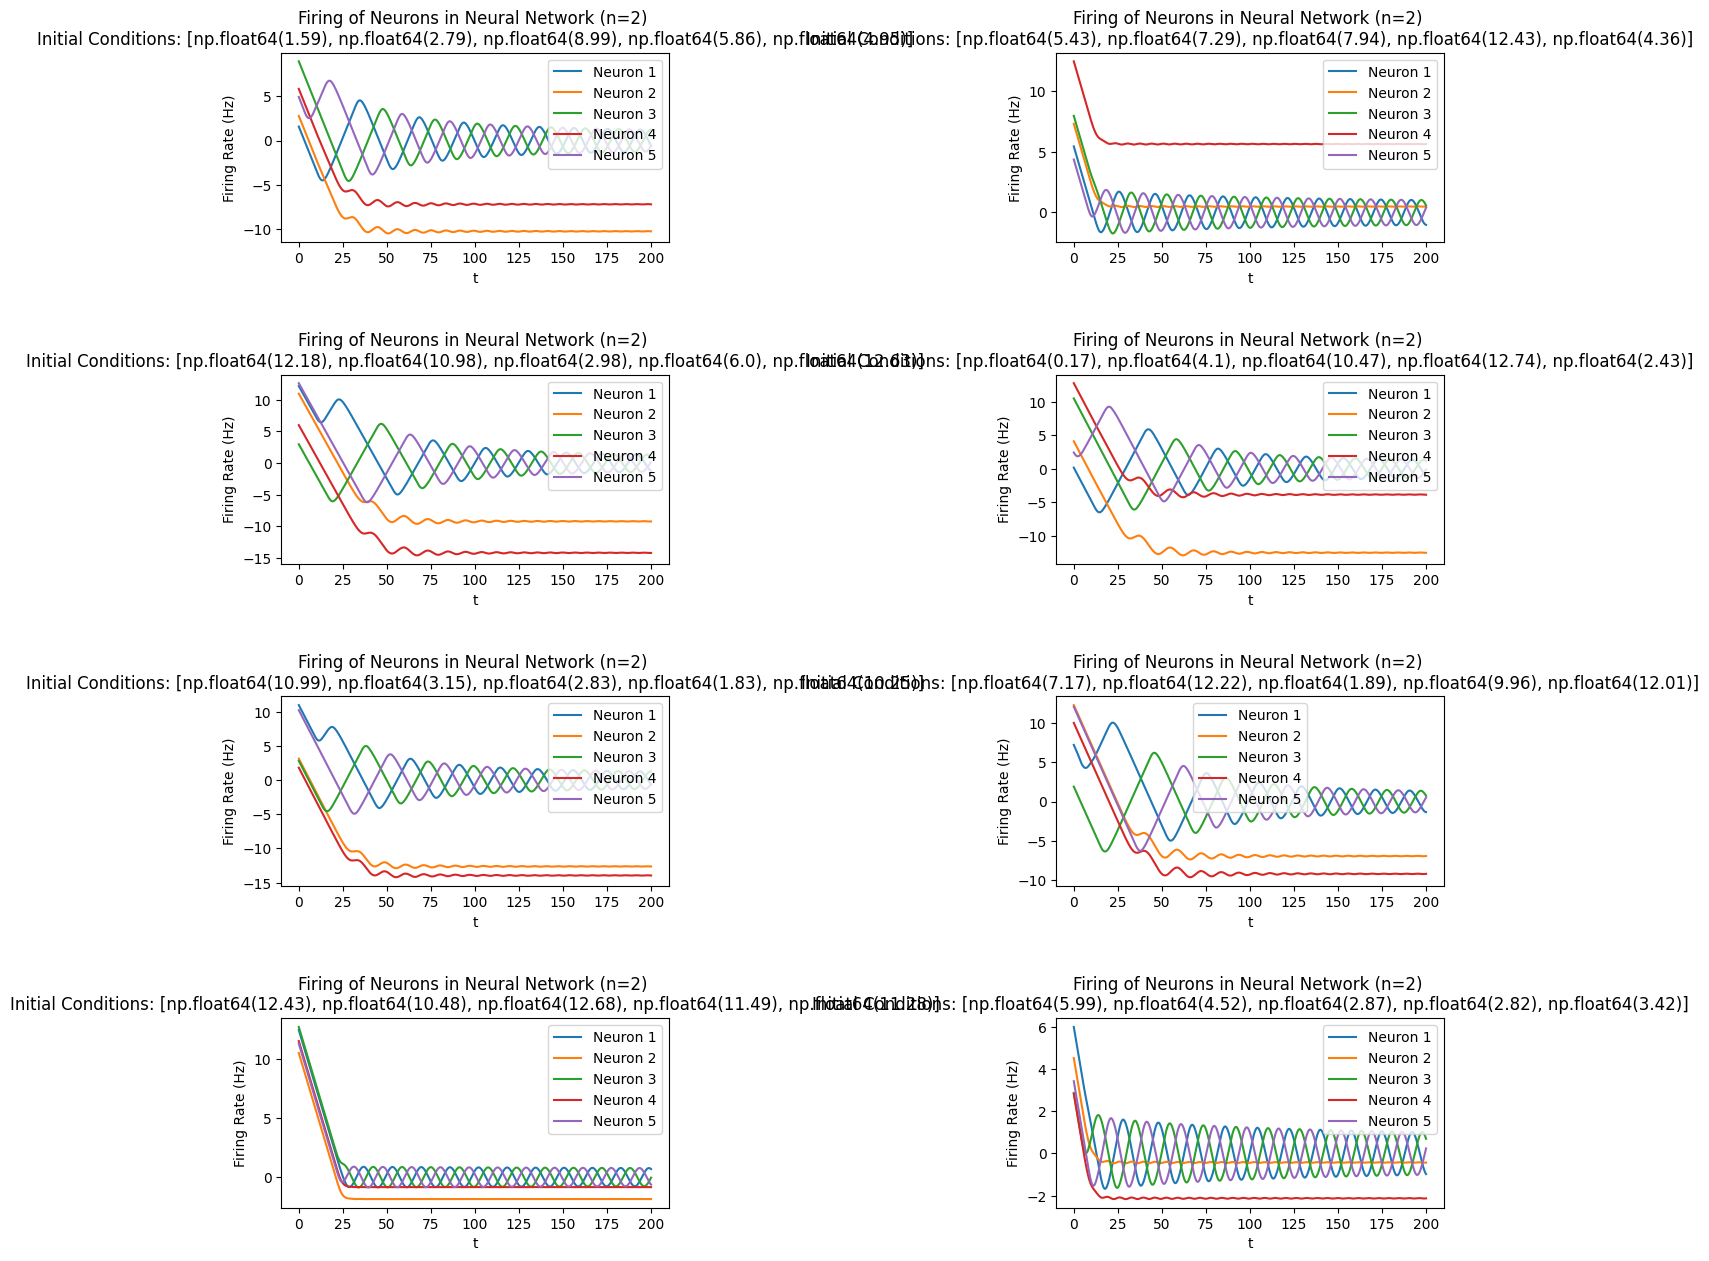

In [16]:
# Simulate a n-size neuron neural network that is bistable, where the "on" neurons oscillate and supress the "off" neurons

num_neurons = 5
num_initial_conditions = 8
# Initializing weighted matrix for bistability and oscillation
W_bistable_multivibrator = np.array([
                                    [-1,0,-2,0,0],
                                    [-1,0,-1,0,-1],
                                    [0,0,-1,0,-2],
                                    [-1,0,-1,0,-1],
                                    [-2,0,0,0,-1]
                                    ])

# Initializing activation bias
# b = np.array([17/4,17/4,17/4,17/4,17/4])
b = np.zeros(num_neurons)
# Setting timestep range for ODE func
time_steps = [0,200]
# Initializing neuron firing rates for all neurons in the neural network to a random real number between 0 Hz and 13 Hz. 
# This range appears to be a reasonable neural firing rates for alpha,delta,theta,and beta brain waves
# The animal is not specified, but assuming brain activity observations are on humans, based on the surronding article context.
# Wikipedia. [Neural oscillation]. Wikipedia. [Online]. Available: https://en.wikipedia.org/wiki/Neural_oscillation (Accessed: Dec. 7, 2024).
# Generate array of different initial conditions
init_neuron_firing_rate_vector = gen_initial_conditions_array(num_initial_conditions,num_neurons)
# Setting up evaluation points for ODE func
t_eval = np.linspace(0, 200, 2000)

# Generate subplot variable
num_rows = 4
num_cols = 2
fig,xn = plt.subplots(num_rows,num_cols,figsize=(15,15))
plt.subplots_adjust(wspace=1, hspace=0.7)

for iter in range(len(init_neuron_firing_rate_vector)):
    # Plot the simulated behavior of a three neuron neural network
    t,y = neuron_ode(W_bistable_multivibrator,init_neuron_firing_rate_vector[iter],time_steps,b,t_eval)

    round_initial_conditions = np.round(init_neuron_firing_rate_vector[iter],2)
    a = xn[int(iter/num_cols), iter%num_cols]
    # Plot the firing of each neuron in neural network
    for i in range(num_neurons):
        a.plot(t, y[i], label=f"Neuron {i+1}")
    a.set_title(f"Firing of Neurons in Neural Network (n=2) \nInitial Conditions: {list(round_initial_conditions)}")
    a.set_xlabel("t")
    a.set_ylabel("Firing Rate (Hz)")
    a.legend()

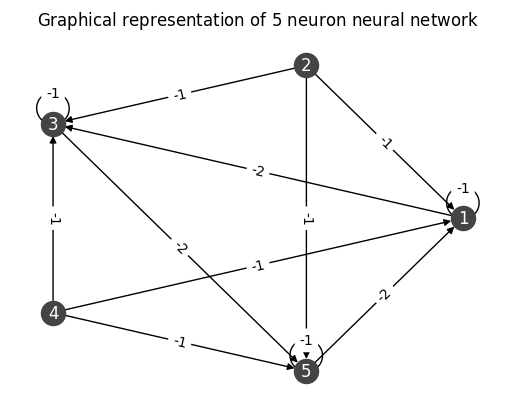

In [17]:
# Graphical representation of bistable multivibrator neural network based on the weighted connection matrix W

# Create networkX graph variable
G_bistable_multivibrator = nx.DiGraph()
G_bistable_multivibrator = gen_nn_nodes(b,G_bistable_multivibrator)
G_bistable_multivibrator = gen_nn_edges(W_bistable_multivibrator,G_bistable_multivibrator)

# Create graph
basic_graph,ax = plt.subplots(1,1)
ax.set_title("Graphical representation of $%d$ neuron neural network" % (5))

draw_nn(G_bistable_multivibrator,ax)

In [18]:
def gen_rand_weight(p_i,lower_bound_i,upper_bound_i):
    """Function takes in a value p which is between [0,1], compares it against a random number between [0,1] and outputs 1,-1, or 0 based on the comparison result
    

    Interface Control Document (ICD)
    | I/O       | Signal Name                       | Description                                                                                                                   |
    | -         | -                                 | -                                                                                                                             |
    | input     | p_i                               | Determines the bounds that the random number will be compared to when determining the output 1, -1, or 0                      |
    | input     | lower_bound_i                     | Determines the lowest possible bound of the random number generator (should be 0 for this project)                            |
    | output    | upper_bound_i                     | Determines the highest possible bound of the random number generator (should be 1 for this project)                           |
    | output    | rand_weight_o                     | Single random weight output (1,-1, or 0)                                                                                      |


    No Exception Handling Provided
    """
    # generate a random seed number between the lower bound and upper bound intervals
    r = random.uniform(lower_bound_i,upper_bound_i)

    # generate a weight based on the random seed number
    if (r <= (p_i/2)):
        rand_weight_o = 1
    elif ((p_i/2) < r < p_i):
        rand_weight_o = -1
    else:
        rand_weight_o = 0
    
    return rand_weight_o

def gen_rand_weight_matrix(num_neurons_i,p_i,lower_bound_i,upper_bound_i):
    """Function generates a random weight matrix of size $nxn$.


    Interface Control Document (ICD)
    | I/O       | Signal Name                       | Description                                                                                                                                   |
    | -         | -                                 | -                                                                                                                                             |
    | input     | num_neurons_i                     | Sets the size of the nxn matrix                                                                                                               |
    | input     | p_i                               | Passed to gen_rand_weight(). Used to determine the bounds that the random number will be compared to when determining the output 1, -1, or 0  |
    | input     | lower_bound_i                     | Passed to gen_rand_weight(). Used to determine the lowest possible bound of the random number generator (should be 0 for this project)        |
    | input     | upper_bound_i                     | Passed to gen_rand_weight(). Used to determine the highest possible bound of the random number generator (should be 1 for this project)       |
    | output    | A_o                               | Weight matrix of size $nxn$ which consists of the following randomly generated numbers (1,-1,0)                                               |


    No Exception Handling Provided
    """

    # Initialize an empty matrix
    A_row = []
    A_o = []

    # Fill out the first row of matrix A_o so that for loop can cycle through remainder or rows
    for i in range(num_neurons_i):
        rand_weight = gen_rand_weight(p_i,lower_bound_i,upper_bound_i)
        A_o.append(rand_weight)
        
    # Fill out each element in matrix A_o (nxn matrix)
    for j in range(num_neurons_i-1):
        for k in range(num_neurons_i):
            rand_weight = gen_rand_weight(p_i,lower_bound_i,upper_bound_i)
            A_row.append(rand_weight)
        A_o = np.vstack((A_o,A_row))
        A_row.clear()

    return A_o

def sub_identity_matrix(num_neurons_i,rand_weight_matrix_i):
    """Subtract the identity matrix fron the random weight matrix to make an offical weight matrix
    


    Interface Control Document (ICD)
    | I/O       | Signal Name                       | Description                                                                                                                                   |
    | -         | -                                 | -                                                                                                                                             |
    | input     | num_neurons_i                     | Sets the size of the nxn identity matrix                                                                                                      |
    | input     | rand_weight_matrix_i              | The random weight matrix generated by gen_rand_weight_matrix(). Matrix should be n-size, which should be equal to num_neurons_i               |
    | output    | W_o                               | Weight matrix of size $nxn$ which consists of the following randomly generated numbers (1,-1,0)                                               |


    No Exception Handling Provided
    """

    I = []
    # Generate the identity matrix
    I = np.identity(num_neurons_i)

    # Generate the weight matrix
    W_o = rand_weight_matrix_i - I

    return W_o


In [19]:
# Random Neural Network with 50 neurons
n = 50
p = 0.5
lower_bound = 0
upper_bound = 1
rand_weight_matrix = gen_rand_weight_matrix(n,p,lower_bound,upper_bound)
W = sub_identity_matrix(n,rand_weight_matrix)
print(W)

[[ 0.  0.  1. ...  0. -1.  0.]
 [ 0. -1.  0. ... -1. -1.  0.]
 [-1.  0.  0. ...  0.  0. -1.]
 ...
 [ 0.  0. -1. ... -2.  1.  0.]
 [ 0.  0.  0. ...  0. -1.  0.]
 [-1.  0.  0. ...  0.  0. -2.]]


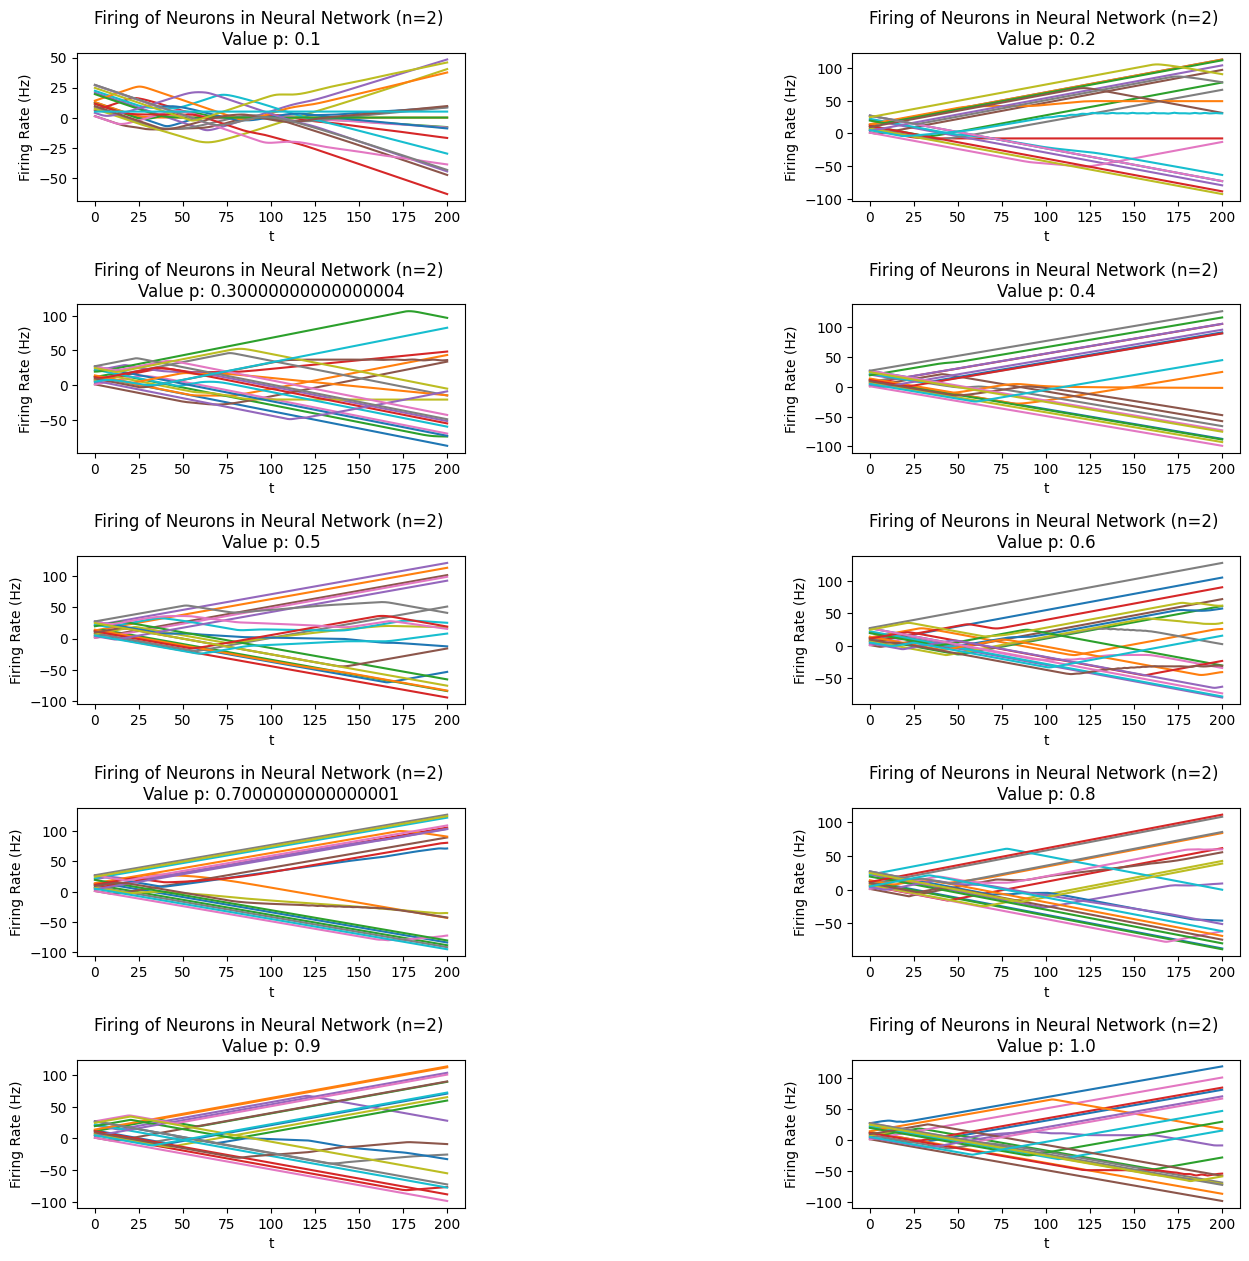

In [20]:
# Simulate 20-neuron neural network with various random adjancency matrices by changing the value p
# Set initial conditons to generate random weight matrices
p = np.linspace(0.1, 1, 10)
n = 20
lower_bound = 0
upper_bound = 1
W_p = []

# Initializing activation bias
b = np.zeros(n)
# Setting timestep range for ODE func
time_steps = [0,200]
# Initializing neuron firing rates for all neurons in the neural network to a random real number between 0 Hz and 13 Hz. 
# This range appears to be a reasonable neural firing rates for alpha,delta,theta,and beta brain waves
# The animal is not specified, but assuming brain activity observations are on humans, based on the surronding article context.
# Wikipedia. [Neural oscillation]. Wikipedia. [Online]. Available: https://en.wikipedia.org/wiki/Neural_oscillation (Accessed: Dec. 7, 2024).
init_neuron_firing_rate_vector = np.array([random.uniform(0,30) for i in range(n)]).reshape(n,)
# Setting up evaluation points for ODE func
t_eval = np.linspace(0, 200, 2000)

# Generate weight matrices
for i in range(len(p)):
    rand_weight_matrix = gen_rand_weight_matrix(n,p[i],lower_bound,upper_bound)
    W_p.append(sub_identity_matrix(n,rand_weight_matrix))

# Generate subplot variable
num_rows = 5
num_cols = 2
fig,xn = plt.subplots(num_rows,num_cols,figsize=(15,15))
plt.subplots_adjust(wspace=1, hspace=0.7)

for iter in range(len(p)):
    # Plot the simulated behavior of a three neuron neural network
    t,y = neuron_ode(W_p[iter],init_neuron_firing_rate_vector,time_steps,b,t_eval)

    a = xn[int(iter/num_cols), iter%num_cols]
    # Plot the firing of each neuron in neural network
    for i in range(n):
        a.plot(t, y[i], label=f"Neuron {i+1}")
    a.set_title(f"Firing of Neurons in Neural Network (n=2) \nValue p: {p[iter]}")
    a.set_xlabel("t")
    a.set_ylabel("Firing Rate (Hz)")